In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

import pandas_profiling

Описания полей

* client_id - идентификатор клиента

* education - уровень образования

* sex - пол заемщика

* age - возраст заемщика

* car - флаг наличия автомобиля

* car_type - флаг автомобиля иномарки

* decline_app_cnt - количество отказанных прошлых заявок

* good_work - флаг наличия “хорошей” работы

* bki_request_cnt - количество запросов в БКИ

* home_address - категоризатор домашнего адреса

* work_address - категоризатор рабочего адреса

* income - доход заемщика

* foreign_passport - наличие загранпаспорта

* sna - связь заемщика с клиентами банка

* first_time - давность наличия информации о заемщике

* score_bki - скоринговый балл по данным из БКИ

* region_rating - рейтинг региона

* app_date - дата подачи заявки

* default - флаг дефолта по кредиту

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
#Объединяем тренировочные и тестовые выборки

df_test['default'] = 0
df_train['sample'] = 1
df_test['sample'] = 0
data = df_train.append(df_test, sort=False).reset_index(drop=True)

In [4]:
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [6]:
#Количество уникальных значений в каждом столбце

data.nunique().sort_values()

sample                   2
default                  2
car_type                 2
car                      2
good_work                2
sex                      2
foreign_passport         2
home_address             3
work_address             3
first_time               4
sna                      4
education                5
region_rating            7
decline_app_cnt         24
bki_request_cnt         40
age                     52
app_date               120
income                1207
score_bki           102618
client_id           110148
dtype: int64

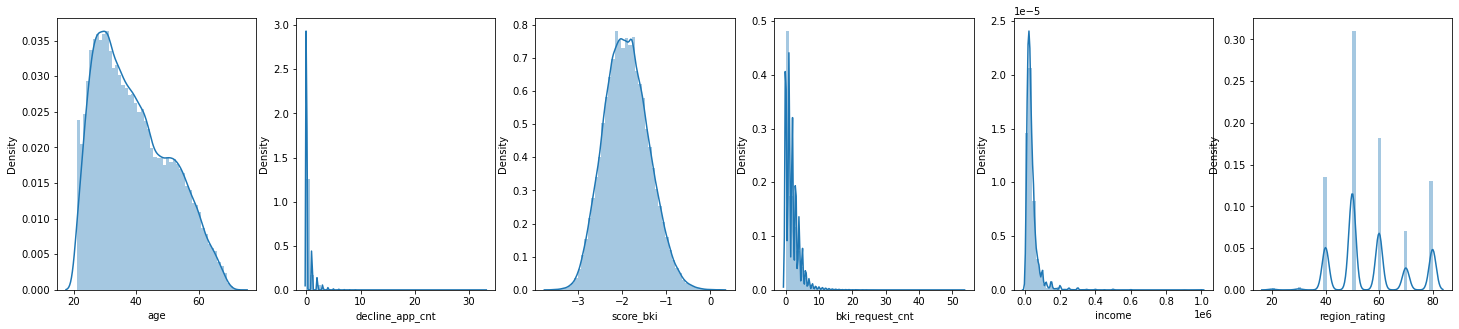

In [7]:
#создаём список столбцов с числовыми значениями и смотрим рапспределение признаков

num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income', 'region_rating']

plt.figure(figsize=(25,5))
for i, s in enumerate(num_cols):
    plt.subplot(1, len(num_cols), i+1)
    sns.distplot(data[s])

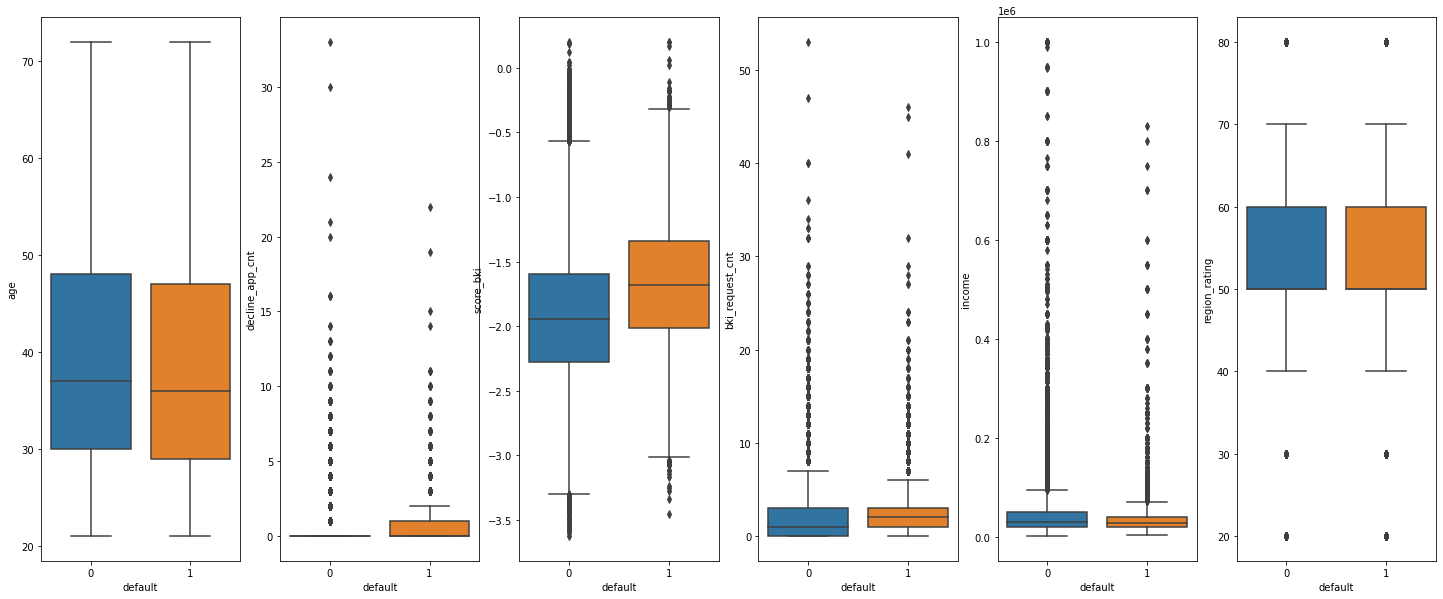

In [8]:
#С помощью построения графика boxplot оцениваем являются ли большие значения выбросами

plt.figure(figsize=(25, 10))

for i, s in enumerate(num_cols):
    plt.subplot(1, len(num_cols), i+1)
    sns.boxplot(x='default', y=s, data=data)

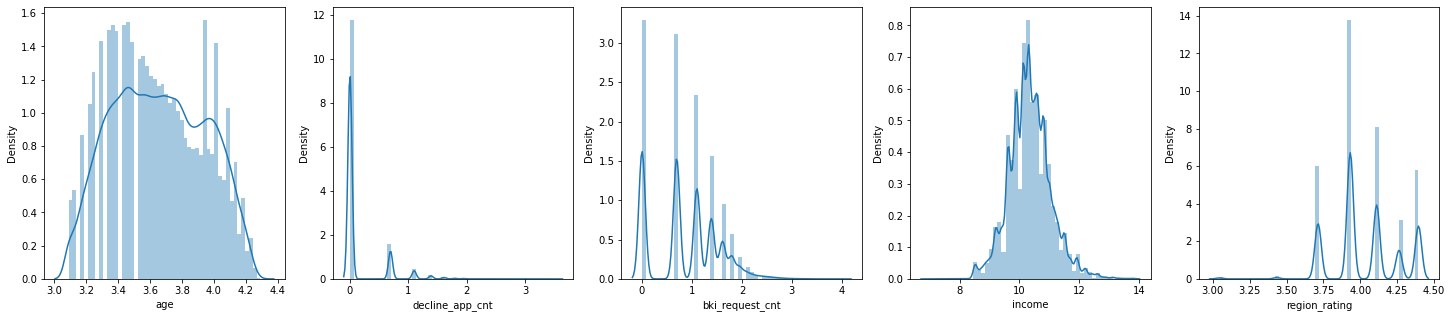

In [9]:
# Нормальное распределение имеет только признак'score_bki', остальные ассиметричны
#Логарифмируем числовые признаки кроме 'score_bki'

num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'region_rating']
for col in num_cols:
    data[col] = np.log(data[col]+1)
    
plt.figure(figsize=(25,5))
for i, s in enumerate(num_cols):
    plt.subplot(1, len(num_cols), i+1)
    sns.distplot(data[s])

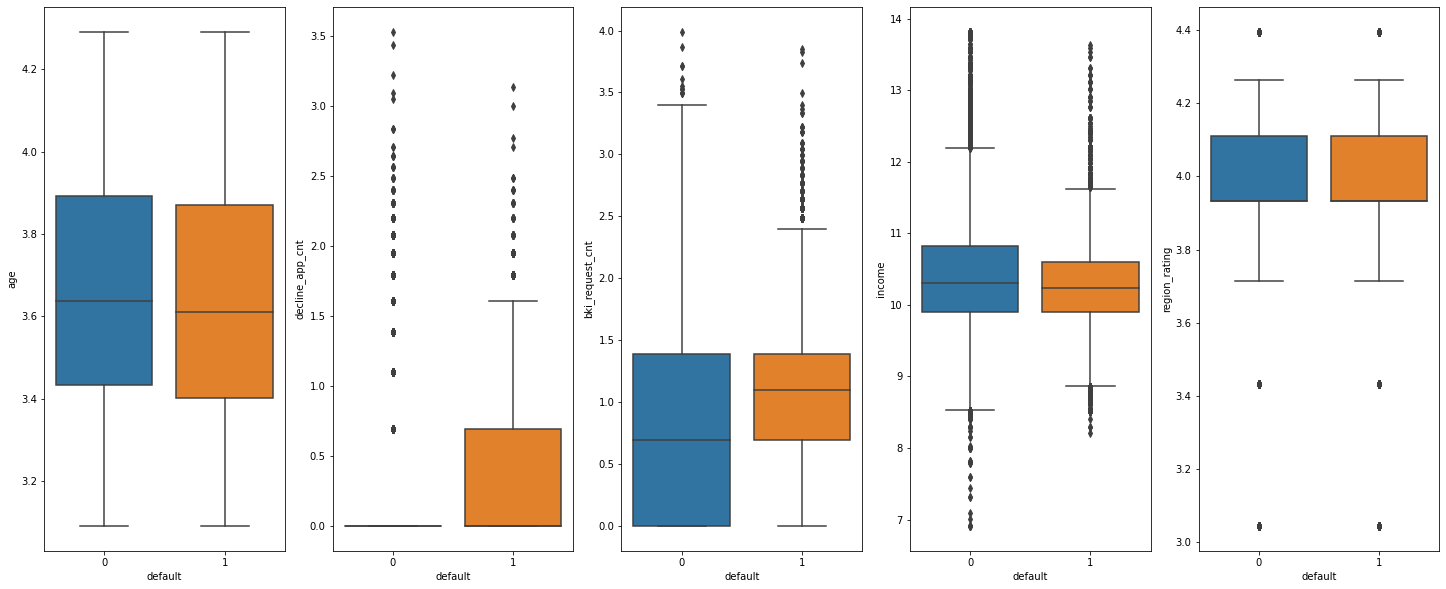

In [10]:
plt.figure(figsize=(25, 10))
for i, s in enumerate(num_cols):
    plt.subplot(1, len(num_cols), i+1)
    sns.boxplot(x='default', y=s, data=data)

<AxesSubplot:>

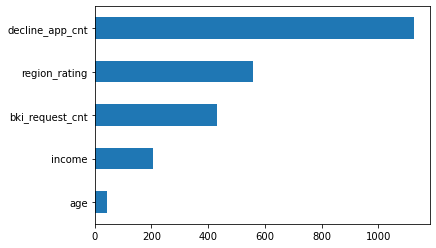

In [11]:
#Посмотрим значимость числовых признаков

pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols).sort_values().plot.barh()

In [12]:
#Рассмотрим бинарные признаки
bin_cols = ['sex', 'car', 'car_type', 'good_work',  'foreign_passport']
for col in bin_cols:
    print(col, ':', data[col].unique())
    print

sex : ['M' 'F']
car : ['Y' 'N']
car_type : ['Y' 'N']
good_work : [0 1]
foreign_passport : ['N' 'Y']


In [13]:
#Строковые значения необходимо перевести в числовой тип

label_encoder = LabelEncoder()
bin_cols = ['sex', 'car', 'car_type', 'good_work',  'foreign_passport']

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

In [14]:
#Рассмотрим категориальные признаки
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time',]

for col in cat_cols:
    print(col, ':', data[col].unique())
    print

education : ['SCH' 'GRD' 'UGR' 'PGR' 'ACD' nan]
home_address : [1 2 3]
work_address : [2 3 1]
sna : [4 1 2 3]
first_time : [1 4 3 2]


<AxesSubplot:>

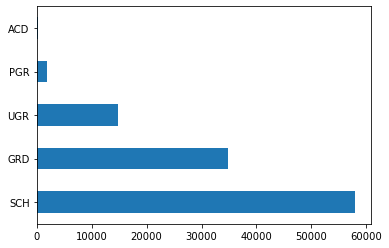

In [15]:
#Столбец с образованием имеет пропуски. Смотрим распределение уровней образования у клиентов.

data['education'].value_counts().plot.barh()

<AxesSubplot:>

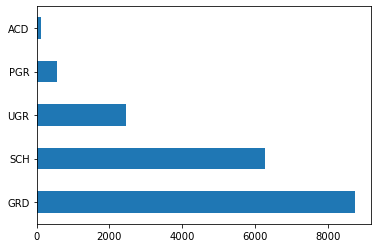

In [16]:
data[data['good_work'] == 1]['education'].value_counts().plot.barh()

<AxesSubplot:>

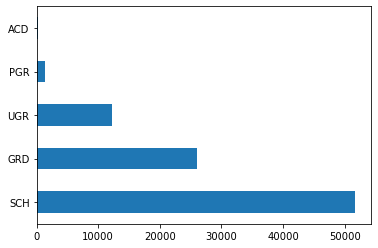

In [17]:
data[data['good_work'] == 0]['education'].value_counts().plot.barh()

Хорошую работу чаще имеют клиенты с образованием 'GRD', и чаще не имеют с образованием 'SCH'. Смотрим, сколько клиентов имеют хорошую работу и не имеют её среди тех, у кого не указан уровень образования. Заполняем пропуски в столбце 'education' значением 'GRD', если клиент имеет хорошую работу, и 'SCH', если не имеет её.

<AxesSubplot:>

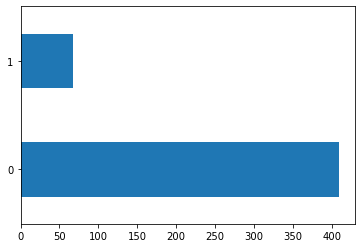

In [18]:
data[data['education'].isnull() == True]['good_work'].value_counts().plot.barh()

In [19]:
for i, v in enumerate(['SCH', 'GRD']):
    data[data['good_work'] == i] = data[data['good_work'] == i].fillna(v)

In [20]:
#Выполняем кодирование признака 'education'

def label(col):
    uniq = data[col].unique()
    data[col] = data[col].map(dict(zip(uniq, range(1, len(uniq)+1))))
    
label('education')

<AxesSubplot:>

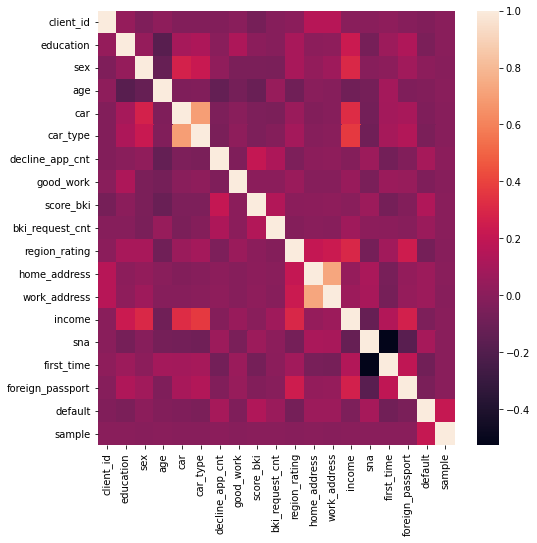

In [21]:
#Смотрим корреляцию признаков

plt.figure(figsize=(8, 8))
sns.heatmap(data.corr())

Высокая положительная корреляция у признаков 'car' и 'car_type', 'home_address' и 'work_address'. Объединим каждую пару в один столбец

In [22]:
data['address'] = data['home_address'] * data['work_address']
data['car_t'] = data['car'] * data['car_type']

In [23]:
#Столбец с датой конвертируем в DateTime и создаем новый столбец с месяцем подачи заявки

data['app_date'] = pd.to_datetime(data['app_date'])
data['month'] = data['app_date'].dt.month

In [24]:
#Удаляем ненужные столбцы
data = data.drop(['client_id', 'app_date', 'home_address',
                  'work_address', 'car', 'car_type'], axis=1)

<AxesSubplot:>

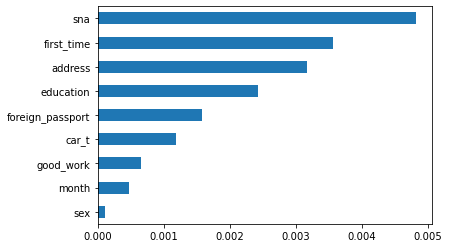

In [25]:
#Посмотрим значимость категориальных признаков

cat_cols = ['education', 'address', 'car_t', 'sna', 'first_time', 'month']
bin_cols = ['sex', 'good_work',  'foreign_passport']
pd.Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'], 
                              discrete_features =True), index = bin_cols + cat_cols).sort_values().plot.barh()

In [26]:
#Проведем унитарное кодирование для категориальных признаков

data = pd.get_dummies(data, columns=cat_cols, prefix=cat_cols)

In [27]:
#Сделаем стандартизацию числовых признаков

data = pd.concat([data.drop(num_cols, axis=1), 
                  pd.DataFrame(StandardScaler().fit_transform(data[num_cols]), columns=num_cols)], axis=1)

In [28]:
#Создаем новые признаки из числовых

data['bki'] = data['bki_request_cnt'] * data['score_bki']
data['bki_income'] = data['income'] * data['score_bki']
data['age_bki'] = data['age'] * data['score_bki']

<AxesSubplot:>

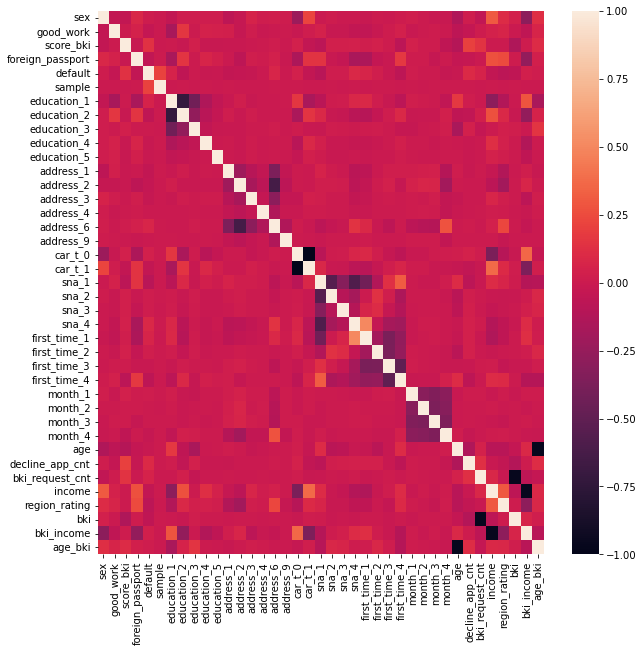

In [29]:
plt.figure(figsize=(10, 10))
sns.heatmap(data.corr())

In [30]:
#Разделяем тренировочную и тестовую выборки

train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)
test_data = test_data.drop('default', axis=1)

Y = train_data['default']
X = train_data.drop(['default'], axis=1)

In [31]:
#Тренировочную выборку разделяем на обучающую и тестовую

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=4)

In [32]:
#Обучаем модель

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

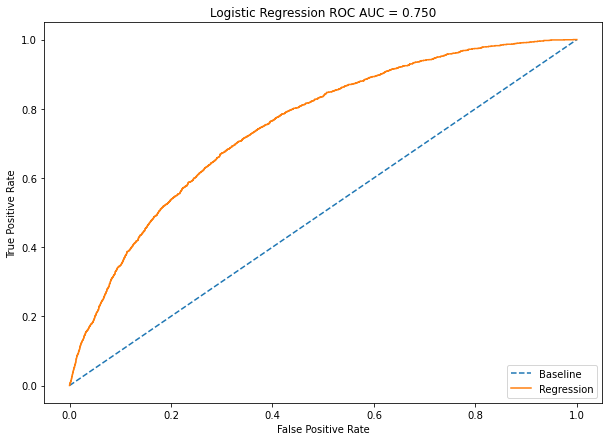

In [33]:
#Вычисляем метрику и строим кривую

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure(figsize=(10,7))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [34]:
#Найдем оптимальное значение параметра регуляризации

from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 20)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
#clf = GridSearchCV(model, param_grid, cv=5, verbose=0)
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)


best_model = clf.fit(X_train, y_train)

best_model.best_params_

{'C': 1.6237767391887217, 'penalty': 'l2'}

In [35]:
#Обучаем модель с найденными параметрами

model = LogisticRegression(C=best_model.best_estimator_.get_params()['C'], 
                           penalty=best_model.best_estimator_.get_params()['penalty'])
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]

roc_auc = roc_auc_score(y_test, probs)
roc_auc

0.7499914131891157